In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Softcom Assignments/Assignment 02/Dataset.csv')
dataset['Sentiment'].replace(to_replace = [-1, 1], value = [0, 1], inplace = True)
display(len(dataset))
display(dataset.head())

5791

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [ ]:
corpus = []
for i in range(len(dataset)):
  s = dataset['Text'][i]
  sl = s.lower().split()
  cv = PorterStemmer()
  sl = [cv.stem(w) for w in sl if not w in set(stopwords.words('english'))]
  corpus.append(' '.join(sl))

dataset['Text'] = corpus
corpus[:20]

['kicker watchlist xide tit soq pnk cpw bpz aj trade method 1 method 2, see prev post',
 'user: aap movie. 55% return fea/ge indic 15 trade year. awesome.',
 "user i'd afraid short amzn - look like near-monopoli ebook infrastructure-as-a-servic",
 'mnta 12.00',
 'oi 21.37',
 'pgnx 3.04',
 'aap - user current downtrend break. otherwis short-term correct med-term downtrend.',
 "monday' rel weakness. nyx win tie tap ice int bmc aon c chk biib",
 'goog - ower trend line channel test & volum support.',
 'aap watch tomorrow ong entry.',
 "i'm assum fcx open tomorrow 34.25 trigger buy. still much like setup.",
 'realli worri everyon expect market ralli now,usu exact opposit happen everi time shall see soon bac spx jpm',
 "aap gamco' arri haverti : appl extrem cheap great video !!!",
 'user maykiljil post that. agre msft go higher & possibl north 30',
 'momentum come back etfc broke ma200 resist solid volum friday. ong set-up',
 'ha hit 35.65 mean resum target 42 level ..',
 'user gameplan sho

In [ ]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super(NN, self).__init__()
        self.linear_0 = nn.Linear(input_dim,100)
        self.linear_1 = nn.Linear(100,100)
        self.linear_2 = nn.Linear(100,100)
        self.linear_3 = nn.Linear(100,100)
        self.linear_4 = nn.Linear(100,100)
        self.linear_5 = nn.Linear(100,50)
        self.linear_6 = nn.Linear(50,50)
        self.linear_7 = nn.Linear(50,50)
        self.linear_8 = nn.Linear(50,1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear_0(x.squeeze(1).float())
        x = self.relu(x)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.linear_3(x)
        x = self.relu(x)
        x = self.linear_4(x)
        x = self.relu(x)
        x = self.linear_5(x)
        x = self.relu(x)
        x = self.linear_6(x)
        x = self.relu(x)
        x = self.linear_7(x)
        x = self.relu(x)
        x = self.linear_8(x)
        return x

In [ ]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=34)

In [ ]:
class Bow(Dataset):
  def __init__(self, data):
    self.vectorizer = CountVectorizer(binary=True)
    self.sequences = self.vectorizer.fit_transform(data['Text'].tolist())
    self.labels = data['Sentiment'].tolist()
    self.token2id = self.vectorizer.vocabulary_
    self.id2token = {id: token for token, id in self.token2id.items()}
  def __getitem__(self, i):
    return self.sequences[i, :].toarray(), self.labels[i]
  def __len__(self):
    return self.sequences.shape[0]

bow_data = Bow(train_set)
bow_train = DataLoader(bow_data, batch_size=50)

In [ ]:
model_bow = NN(len(bow_data.token2id))
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer1 = optim.SGD(model_bow.parameters(), lr=0.01)

Epoch 1 Loss 0.6786738435427347
Epoch 2 Loss 0.6680046634007526
Epoch 3 Loss 0.6622033535793264
Epoch 4 Loss 0.659009345757064
Epoch 5 Loss 0.657301579752276
Epoch 6 Loss 0.656404258102499
Epoch 7 Loss 0.6559261846285994
Epoch 8 Loss 0.655671783672866
Epoch 9 Loss 0.655537034234693
Epoch 10 Loss 0.6554658393706044
Epoch 11 Loss 0.6554283038262398
Epoch 12 Loss 0.6554085394387604
Epoch 13 Loss 0.6553981316986904
Epoch 14 Loss 0.6553926493531914
Epoch 15 Loss 0.6553897530801834
Epoch 16 Loss 0.6553882245094546
Epoch 17 Loss 0.6553874079899121
Epoch 18 Loss 0.655386971530094
Epoch 19 Loss 0.6553867318296945
Epoch 20 Loss 0.6553866010840221


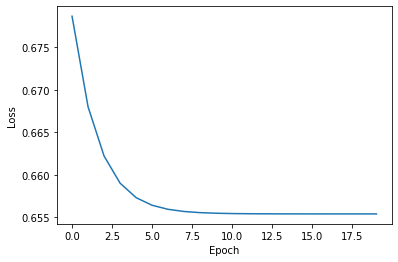

In [ ]:
epoch = 20
loss_per_epoch = []

for i in range(epoch):
  losses = []
  for d in bow_train:
    x, y = d
    model_bow.zero_grad()
    outputs = model_bow(x)
    loss = loss_fn1(outputs.squeeze(), y.float())
    loss.backward()
    optimizer1.step()
    losses.append(loss.item())

  loss_per_epoch.append(sum(losses)/len(losses))
  print('Epoch', i + 1, 'Loss', loss_per_epoch[-1])

plt.plot(loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
pred_y = []
x = list(test_set['Text'])
y = test_set['Sentiment']

for line in x:
  test_vector = torch.LongTensor(bow_data.vectorizer.transform([line]).toarray())
  output = model_bow(test_vector)
  pred = round(torch.sigmoid(output).item())
  pred_y.append(pred)

accuracy = accuracy_score(y, pred_y)
print('Accuracy', accuracy)

Accuracy 0.635030198446937


In [ ]:
class Tfidf(Dataset):
  def __init__(self, data):
    self.vectorizer = TfidfVectorizer(binary=True)
    self.sequences = self.vectorizer.fit_transform(data['Text'].tolist())
    self.labels = data['Sentiment'].tolist()
    self.token2id = self.vectorizer.vocabulary_
    self.id2token = {id: token for token, id in self.token2id.items()}
  def __getitem__(self, i):
    return self.sequences[i, :].toarray(), self.labels[i]
  def __len__(self):
    return self.sequences.shape[0]

tfidf_data = Tfidf(train_set)
tfidf_train = DataLoader(tfidf_data, batch_size=50)

In [ ]:
model_tfidf = NN(len(tfidf_data.token2id))
loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.SGD(model_tfidf.parameters(), lr=0.01)

Epoch 1 Loss 0.6917468854176101
Epoch 2 Loss 0.6749001228681175
Epoch 3 Loss 0.6657404508641971
Epoch 4 Loss 0.6608444394603852
Epoch 5 Loss 0.6582325158580657
Epoch 6 Loss 0.6568581724679599
Epoch 7 Loss 0.6561428340532447
Epoch 8 Loss 0.6557741017751796
Epoch 9 Loss 0.6555862772849298
Epoch 10 Loss 0.655490283684064
Epoch 11 Loss 0.6554409989746668
Epoch 12 Loss 0.6554157259643719
Epoch 13 Loss 0.6554027827837134
Epoch 14 Loss 0.6553961980727411
Epoch 15 Loss 0.6553928236807546
Epoch 16 Loss 0.6553910791233022
Epoch 17 Loss 0.6553901972309235
Epoch 18 Loss 0.6553897261619568
Epoch 19 Loss 0.6553894896661082
Epoch 20 Loss 0.6553893493067834


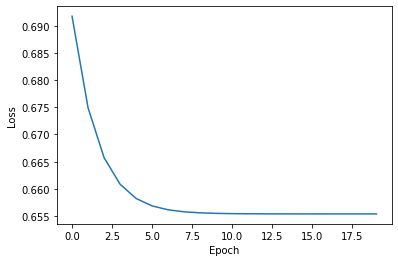

In [ ]:
epoch = 20
loss_per_epoch = []

for i in range(epoch):
  losses = []
  for d in tfidf_train:
    x, y = d
    model_tfidf.zero_grad()
    outputs = model_tfidf(x)
    loss = loss_fn2(outputs.squeeze(), y.float())
    loss.backward()
    optimizer2.step()
    losses.append(loss.item())

  loss_per_epoch.append(sum(losses)/len(losses))
  print('Epoch', i + 1, 'Loss', loss_per_epoch[-1])

plt.plot(loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
pred_y = []
x = list(test_set['Text'])
y = test_set['Sentiment']
for line in x:
  test_vector = torch.LongTensor(tfidf_data.vectorizer.transform([line]).toarray())
  output = model_tfidf(test_vector)
  pred = round(torch.sigmoid(output).item())
  pred_y.append(pred)

accuracy = accuracy_score(y, pred_y)
print('Accuracy', accuracy)

Accuracy 0.569830973430146
